<a href="https://colab.research.google.com/github/marissa-graham/multiagent_systems/blob/master/Consensus_and_Topology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tqdm
import pylab
import seaborn
import numpy as np
import networkx as nx

from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# Probable connectivity

R=0.25/5.0:   5%|▌         | 5/100 [00:00<00:02, 34.91it/s]


########## num_agents: 10 ##########



N=9/10: 100%|██████████| 10/10 [00:00<00:00, 21.61it/s]

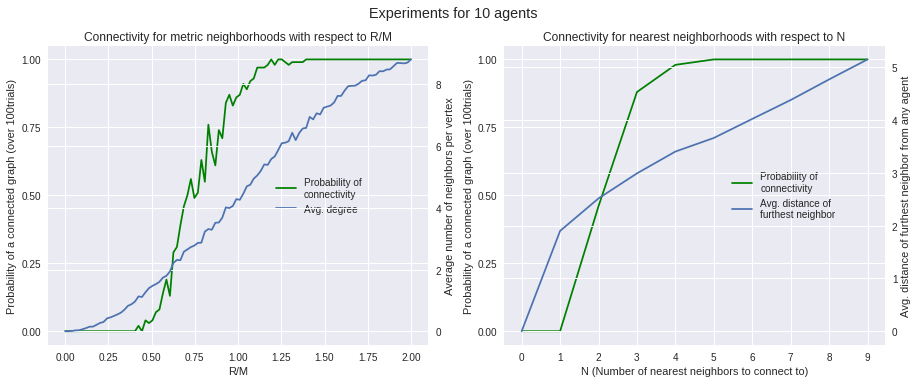

R=0.1/5.0:   3%|▎         | 3/100 [00:00<00:04, 22.10it/s]


########## num_agents: 25 ##########



N=24/25: 100%|██████████| 25/25 [00:02<00:00,  8.84it/s]

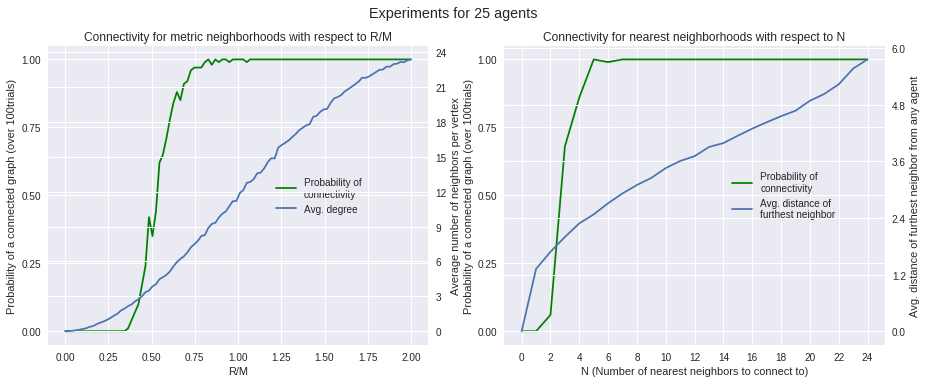

R=0.05/5.0:   2%|▏         | 2/100 [00:00<00:05, 18.31it/s]


########## num_agents: 50 ##########



N=49/50: 100%|██████████| 50/50 [00:15<00:00,  5.17it/s]

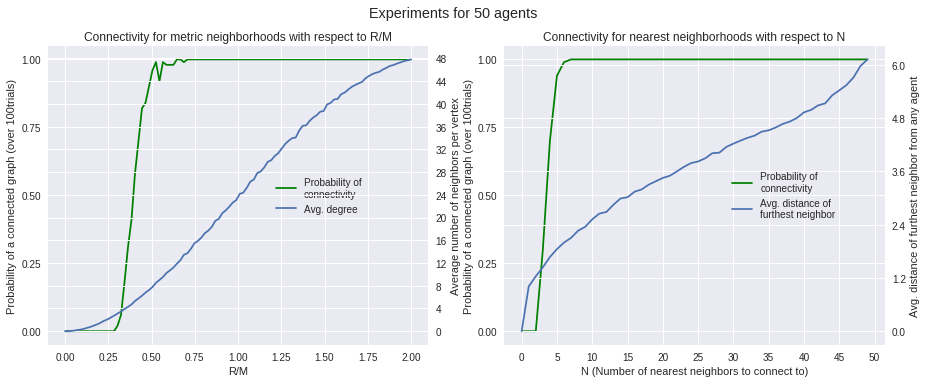

R=0.0/5.0:   0%|          | 0/100 [00:00<?, ?it/s]


########## num_agents: 100 ##########



N=99/100: 100%|██████████| 100/100 [03:05<00:00,  1.55it/s]

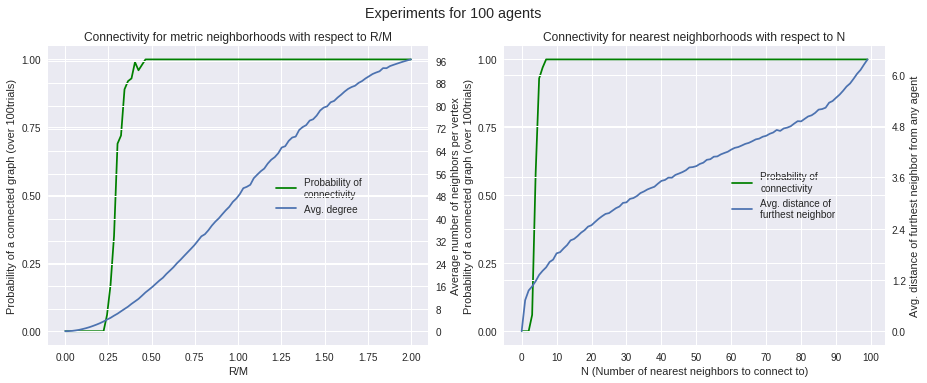

In [0]:
def get_matrices(num_agents=10, M=2.5, R=1, N=2, get_Ar=False, get_An=False,
                 draw=False):
    
    # Randomly place agents in 2d space
    locs = 2*M*np.random.rand(2,num_agents) - M
    loc_dict = {i:locs[:,i] for i in range(num_agents)}
    
    # Calculate metric distances between different agents
    distances = np.empty((num_agents, num_agents))
    for i in range(num_agents):
        distances[i,:] = la.norm(locs - locs[:,i].reshape((2,1)), axis=0)
    
    # Connect agents within a fixed distance
    if get_Ar:
        Ar = np.copy(distances)
        Ar[Ar > R] = 0
        Ar[Ar > 0] = 1
        return Ar, None, np.count_nonzero(Ar)/num_agents
    
    # Connect agents with their N nearest neighbors
    An = np.copy(distances)
    if get_An:
        for i in range(num_agents):
            An[i,:][An[i,:]>np.sort(An[i,:])[N]] = 0
        furthestnearest = np.max(An)
        An[An > 0] = 1  
        return None, An, furthestnearest
    
    # Show the two graphs (optional)
    if draw:
        pylab.rcParams['figure.figsize'] = (10,5)
        fig, (ax1, ax2) = plt.subplots(1,2)
        
        nx.draw(nx.from_numpy_matrix(Ar), ax=ax1, pos=loc_dict, node_size=100)
        ax1.set_title('Connect agents within distance '+str(np.round(R,2)))
        ax1.axis(1.1*np.array([-M, M, -M, M]))
        ax1.axis('on')
        
        nx.draw(nx.from_numpy_matrix(An), ax=ax2, pos=loc_dict, node_size=100)
        ax2.set_title('Connect to nearest ' + str(N) + ' neighbors')
        ax2.axis(1.1*np.array([-M, M, -M, M]))
        ax2.axis('on')
        
        fig.show()
        
    return Ar, An, 0

M = 2.5
num_trials = 100

for num_agents in [10,25,50,100]:
    print("\n########## num_agents:", num_agents, "##########\n")
    
    R_vals = np.linspace(0,2*M,100)
    N_vals = np.arange(num_agents)
    pylab.rcParams['figure.figsize'] = (15,5.5)

    loop = tqdm.tqdm(total=len(R_vals), position=0, leave=True)
    Ar_probs = []
    avg_degrees = []

    for R in R_vals:

        num_connected = 0
        mean_degree = 0
        loop.set_description("R="+str(np.round(R,2))+"/"+str(2*M))
        loop.update(1)

        for i in range(num_trials):

            Ar, An, degree = get_matrices(num_agents=num_agents, R=R, M=M,
                                                  get_Ar = True)
            mean_degree += degree
            Dr = np.diag(np.sum(Ar,axis=0))
            if np.sort(np.real(la.eigvals(Dr - Ar)))[1] > 0:
                num_connected += 1

        Ar_probs.append(num_connected/num_trials) 
        avg_degrees.append(mean_degree/num_trials)

    fig, (ax1, ax2) = plt.subplots(1,2)

    ax1.plot(R_vals/M, Ar_probs, label='Probability of                     \nconnectivity', color='g')
    ax1.set_xlabel("R/M")
    ax1.set_yticks([0,0.25,0.5,0.75,1])
    ax1.set_ylabel("Probability of a connected graph (over "+str(num_trials)+"trials)")

    ax12 = ax1.twinx()
    ax12.plot(R_vals/M, avg_degrees)
    ax1.plot(0,0, label='Avg. degree')
    
    ax12.set_yticks(np.arange(0,num_agents,np.round(num_agents/15)+1))
    ax12.set_ylabel("Average number of neighbors per vertex")

    ax1.set_title("Connectivity for metric neighborhoods with respect to R/M")
    ax1.legend(loc=7)

    loop = tqdm.tqdm(total=len(N_vals), position=0, leave=True)
    An_probs = []
    furthest_neighbors = []

    for N in N_vals:

        num_connected = 0
        loop.set_description("N="+str(N)+"/"+str(num_agents))
        loop.update(1)
        avg_furthest_neighbor = 0

        for i in range(num_trials):

            Ar, An, furthestnearest = get_matrices(num_agents=num_agents, N=N,
                                                  get_An=True)
            avg_furthest_neighbor += furthestnearest
            Dn = np.diag(np.sum(An,axis=0))
            if np.sort(np.real(la.eigvals(Dn - An)))[1] > 0:
                num_connected += 1

        An_probs.append(num_connected/num_trials)  
        furthest_neighbors.append(avg_furthest_neighbor/num_trials)
    ax2.plot(N_vals, An_probs, label="Probability of                     \nconnectivity", color='g')
    ax2.set_xlabel("N (Number of nearest neighbors to connect to)")
    ax2.set_xticks(np.arange(0,num_agents+1,np.round(num_agents/10)))
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    ax2.set_ylabel("Probability of a connected graph (over "+str(num_trials)+"trials)")

    ax22 = ax2.twinx()
    ax22.plot(N_vals, furthest_neighbors)
    ax2.plot(0,0,label='Avg. distance of\nfurthest neighbor')
    
    d = np.round(np.max(furthest_neighbors,-1))
    ax22.set_yticks(np.round(np.linspace(0,d,6),1))
    ax22.set_ylabel("Avg. distance of furthest neighbor from any agent")
    
    ax2.set_title("Connectivity for nearest neighborhoods with respect to N")
    ax2.legend(loc=7)
          
    fig.suptitle("Experiments for "+str(num_agents)+" agents")
    plt.show()

# Dynamics

In [0]:
def get_laplacians(x, repulsion_frac, inner_attraction_frac, 
                   outer_attraction_frac, attraction_type='distance', N=5):
    """
    attraction_type is 'distance' or 'neighbors'
    N is number of neighbors to be attracted to
    """
    
    num_agents = x.shape[1]
    
    # Calculate metric distances between different agents
    distances = np.empty((num_agents, num_agents))
    for i in range(num_agents):
        distances[i,:] = la.norm(x - x[:,i].reshape((2,1)), axis=0)
        
    # Calculate attraction and repulsion radii
    min_dist, max_dist = np.min(distances), np.max(distances)
    dist_range = max_dist - min_dist
    repulsion_radius = min_dist + repulsion_frac*dist_range
    inner_attraction_radius = min_dist + inner_attraction_frac*dist_range
    outer_attraction_radius = min_dist + outer_attraction_frac*dist_range
    
    if attraction_type == 'distance':
        
        # Repulsion graph
        Ar = np.copy(distances)
        Ar[Ar > repulsion_radius] = 0

        # Attraction graph
        Aa = np.copy(distances)
        
        # Zero out agents not between attraction radii
        Aa[Aa < inner_attraction_radius] = 0
        Aa[Aa > outer_attraction_radius] = 0
    
    elif attraction_type == 'neighbors':
        
        # Connect agents with their N nearest neighbors
        A = np.copy(distances)
        for i in range(num_agents):
            A[i,:][A[i,:]>np.sort(A[i,:])[N]] = 0
            
        # Neighbors that are inside the radius of repulsion go in L_R
        Ar = np.copy(A)
        Ar[Ar >= repulsion_radius] = 0
        
        # Neighbors that are outside the radius of repulsion go in L_A
        Aa = np.copy(A)
        Aa[Aa < repulsion_radius] = 0
    
    # Set positive values to 1 to create adjacency matrices, compute Laplacians
    Ar[Ar > 0] = 1
    L_R = np.diag(np.sum(Ar,axis=0)) - Ar
    Aa[Aa > 0] = 1
    L_A = np.diag(np.sum(Aa,axis=0)) - Aa
    
    return L_A, L_R, distances

def update_dynamics(x, L_A, L_R, repulsion_frac, 
                    inner_attraction_frac, outer_attraction_frac,
                    dt=0.01, noise_scale=1e-5, N=5, attraction_type='distance'):
    
    """
    x is a 2 x num_agents numpy array; xcoords and ycoords
    """
    noise = noise_scale*np.random.rand(2, x.shape[1])

    x[0,:] += -np.dot(L_A, x[0,:])*dt + np.dot(L_R, x[0,:])*dt + noise[0,:]*dt
    x[1,:] += -np.dot(L_A, x[1,:])*dt + np.dot(L_R, x[1,:])*dt + noise[1,:]*dt
    
    L_A, L_R, d = get_laplacians(x, repulsion_frac, inner_attraction_frac, 
                              outer_attraction_frac, 
                              attraction_type=attraction_type, N=N)
    
    return x, L_A, L_R, d

def run_experiment(num_agents, attraction_type, N, repulsion_frac, 
                   inner_attraction_frac, outer_attraction_frac):
    
    if attraction_type == 'distance':
        print("Run distance-attraction experiment for", num_agents,
              "agents\nRepulsion cutoff", repulsion_frac, 
              "\nAttraction between", inner_attraction_frac, "and",
              outer_attraction_frac)#, "\nN =", N)
    else:
        print("Run neighbors-attraction experiment for", num_agents,
              "agents\nN =", N, "\nRepulsion cutoff", repulsion_frac)
        
    x = np.random.rand(2,num_agents)
    
    L_A, L_R, d = get_laplacians(x, repulsion_frac, inner_attraction_frac, 
                              outer_attraction_frac,
                              attraction_type=attraction_type, N=N)
    L_A_fiedlers = [np.real(la.eigvals(L_A))[1]]
    L_R_fiedlers = [np.real(la.eigvals(L_R))[1]]
    num_edges = np.count_nonzero(L_A) - np.count_nonzero(np.diag(L_A))
    A_avg_degrees = [num_edges/num_agents]
    locs = [np.copy(x)]
    
    not_done = True

    while not_done:
        
        x, L_A, L_R, d = update_dynamics(x, L_A, L_R, repulsion_frac,
                                  inner_attraction_frac, outer_attraction_frac,
                                  attraction_type=attraction_type, N=N)
        locs.append(np.copy(x))
        L_A_fiedlers.append(np.real(la.eigvals(L_A))[1])
        L_R_fiedlers.append(np.real(la.eigvals(L_R))[1])
        
        num_edges = np.count_nonzero(L_A) - np.count_nonzero(np.diag(L_A))
        A_avg_degrees.append(num_edges/num_agents)
        
        if la.norm(locs[-1] - locs[-2], ord=np.inf) < 5e-5:
            not_done = False
        if len(locs) > 200:
            not_done = False
    
    print(len(locs), "iterations to convergence")
    
    fig = plt.figure(figsize=(15,7.5))
    grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.32)
    fiedler_ax = fig.add_subplot(grid[:1,:2])
    avg_deg_ax = fig.add_subplot(grid[:1,2:])
    
    # Scatter the fiedler eigenvalues
    d = np.arange(len(locs))
    fiedler_ax.scatter(d, L_A_fiedlers, label='Attraction graph')
    fiedler_ax.scatter(d, L_R_fiedlers, label='Repulsion graph')
    
    # Draw lines between each lower fiedler to higher fiedler
    mycolors = []
    blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    green =  plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    for i in range(len(locs)):
        if L_A_fiedlers[i] >= L_R_fiedlers[i]: mycolors.append(blue)
        else: mycolors.append(green)
    fiedler_ax.vlines(d, L_R_fiedlers, L_A_fiedlers, colors=mycolors)
    fiedler_ax.set_title("Fiedler eigenvalues over time")
    fiedler_ax.set_ylim(0,1.2*max(np.max(L_A_fiedlers),np.max(L_R_fiedlers)))
    fiedler_ax.set_xticks(np.arange(0,len(locs),int(len(locs)/15)))
    fiedler_ax.set_xlabel('Number of iterations')
    fiedler_ax.legend()
    
    # Plot the average degree for the attraction matrix
    avg_deg_ax.plot(d, A_avg_degrees, label='Avg. degree for attraction graph')
    avg_deg_ax.set_title('Average degree in attraction graph over time')
    avg_deg_ax.set_xlabel('Number of iterations')
    
    # Plot the agent positions over time
    inds = [0, int(0.1*len(locs)), int(0.9*len(locs)), -1]
    titles = ["Initial agent positions", 
              "Positions after "+str(inds[1])+" iterations",
              "Positions after "+str(inds[2])+" iterations",
              "Final agent positions"]
    for i in range(4):
        ax = fig.add_subplot(grid[1,i])
        ax.scatter(locs[inds[i]][0,:], locs[inds[i]][1,:])
        ax.set_title(titles[i])
        ax.set_xlim(0,max(1,np.max(locs[inds[i]][0,:])))
        ax.set_ylim(0,max(1,np.max(locs[inds[i]][1,:])))
        
    if attraction_type == 'distance':
        fulltitle = "Distance-attraction experiment with " + str(num_agents) 
        fulltitle += " agents, repulsion radius " + str(repulsion_frac)
        fulltitle += ", attraction radii (" + str(inner_attraction_frac)
        fulltitle += ", " + str(outer_attraction_frac) + ")"
    else:
        fulltitle = "Neighbors-attraction experiment with " + str(num_agents)
        fulltitle += " agents, N=" + str(N)
        fulltitle += ", repulsion radius " + str(repulsion_frac)
                
    fig.suptitle(fulltitle)
    plt.show()


# Distance-attraction 

### Vary placement of smallish attraction band with a moderate repulsion radius

Run distance-attraction experiment for 30 agents
Repulsion cutoff 0.08 
Attraction between 0.15 and 0.25
201 iterations to convergence


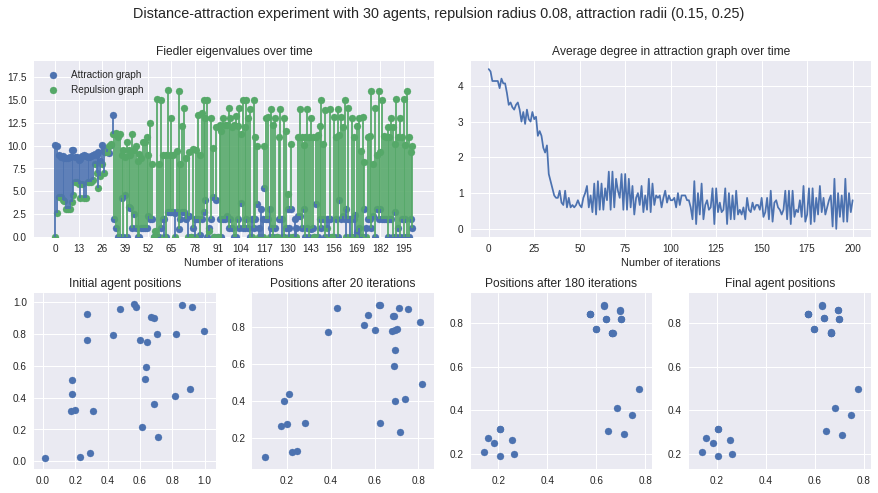

In [0]:
run_experiment(30, 'distance', 10, 0.08, 0.15, 0.25)

Run distance-attraction experiment for 30 agents
Repulsion cutoff 0.08 
Attraction between 0.3 and 0.4
201 iterations to convergence


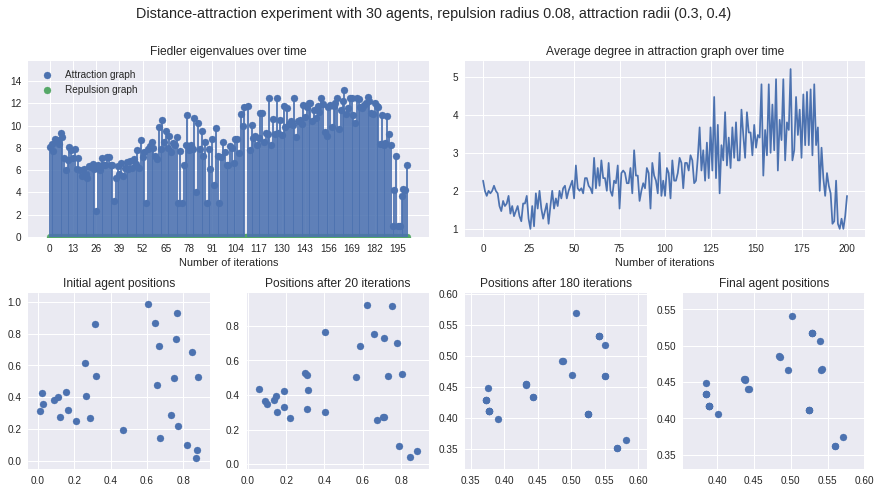

In [0]:
run_experiment(30, 'distance', 10, 0.08, 0.30, 0.40)

Run distance-attraction experiment for 30 agents
Repulsion cutoff 0.08 
Attraction between 0.7 and 0.8
201 iterations to convergence


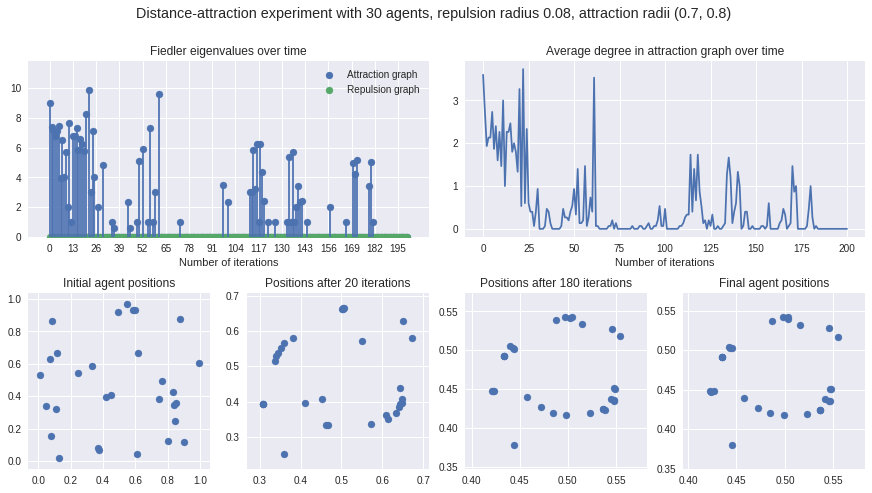

In [0]:
run_experiment(30, 'distance', 10, 0.08, 0.7, 0.8)

Run distance-attraction experiment for 35 agents
Repulsion cutoff 0.3 
Attraction between 0.35 and 0.4
201 iterations to convergence


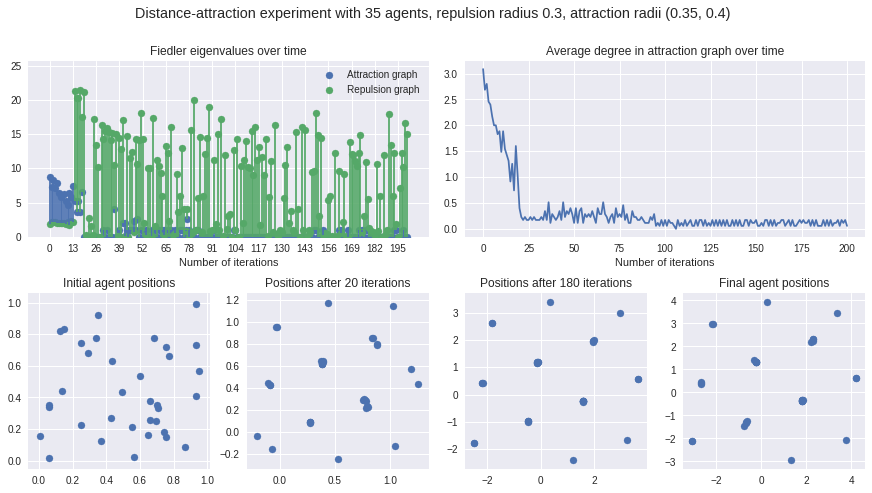

In [0]:
run_experiment(35, 'distance', 10, 0.3, 0.35, 0.4)

### Vary size or placement of an attraction that starts close to a large repulsion radius


Run distance-attraction experiment for 35 agents
Repulsion cutoff 0.3 
Attraction between 0.65 and 0.7
201 iterations to convergence


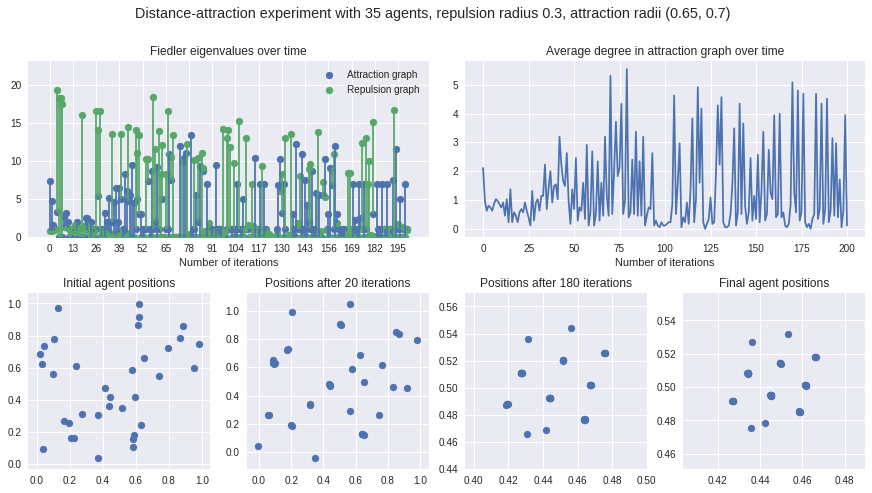

In [0]:
run_experiment(35, 'distance', 10, 0.3, 0.65, 0.7)

Run distance-attraction experiment for 40 agents
Repulsion cutoff 0.01 
Attraction between 0.02 and 0.2
201 iterations to convergence


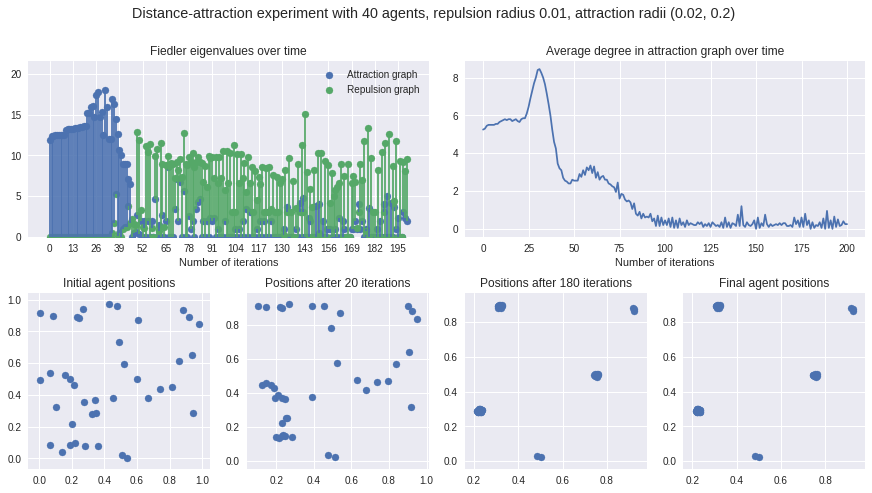

In [0]:
# num_agents, "distance" or "neighbors", N, repulsion radius, attraction radius, outer attraction radius
run_experiment(40, 'distance', 10, 0.01, 0.02, 0.2)

### Vary  size of a close attraction band with a tiny repulsion radius


Run distance-attraction experiment for 40 agents
Repulsion cutoff 0.01 
Attraction between 0.03 and 0.1
201 iterations to convergence


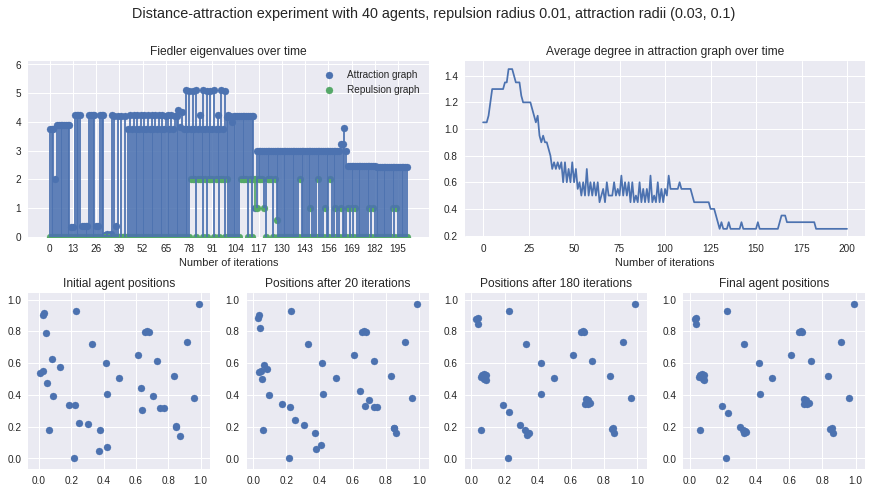

In [0]:
run_experiment(40, 'distance', 40, 0.01, 0.03, 0.1)

# Neighbor experiments

### Vary number of neighbors, same repulsion radius

Run neighbors-attraction experiment for 50 agents
N = 5 
Repulsion cutoff 0.05
201 iterations to convergence


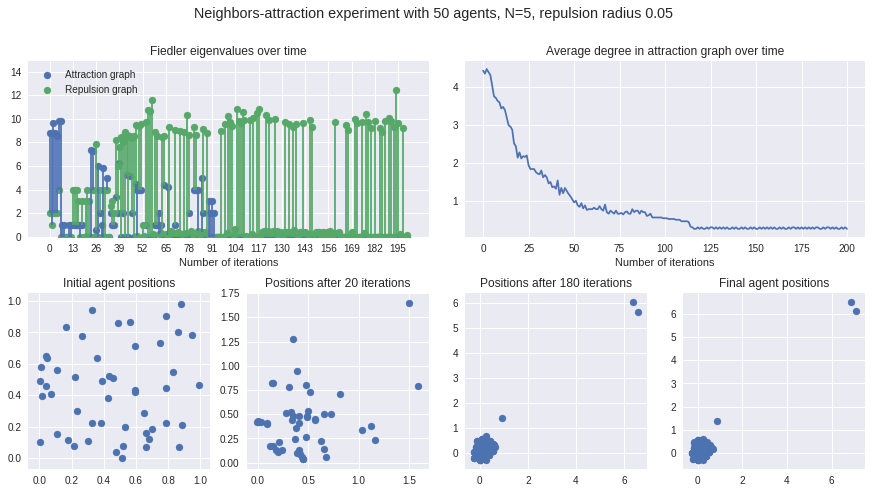

In [0]:
# Attraction radii don't matter at all
run_experiment(50, 'neighbors', 5, 0.05, 0.1, 0.5) 

Run neighbors-attraction experiment for 50 agents
N = 10 
Repulsion cutoff 0.05
201 iterations to convergence


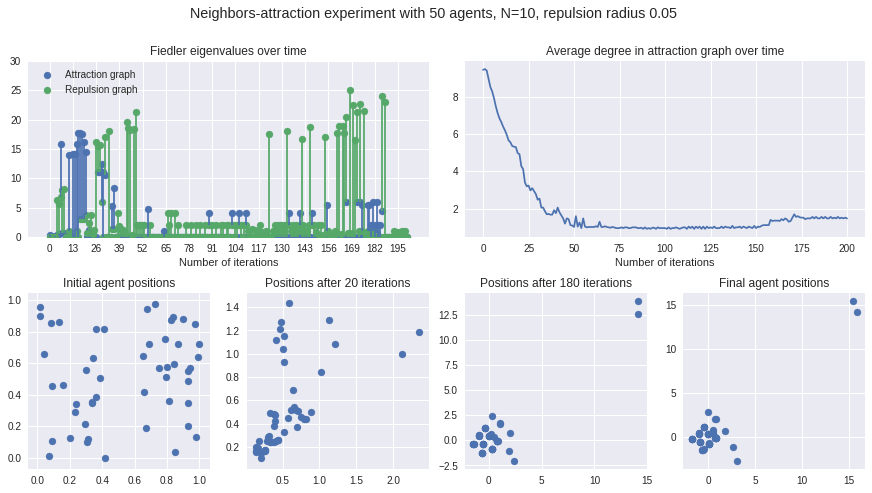

In [0]:
run_experiment(50, 'neighbors', 10, 0.05, 0.1, 0.5) 

### Vary size of repulsion radius

Run neighbors-attraction experiment for 50 agents
N = 10 
Repulsion cutoff 0.1
201 iterations to convergence


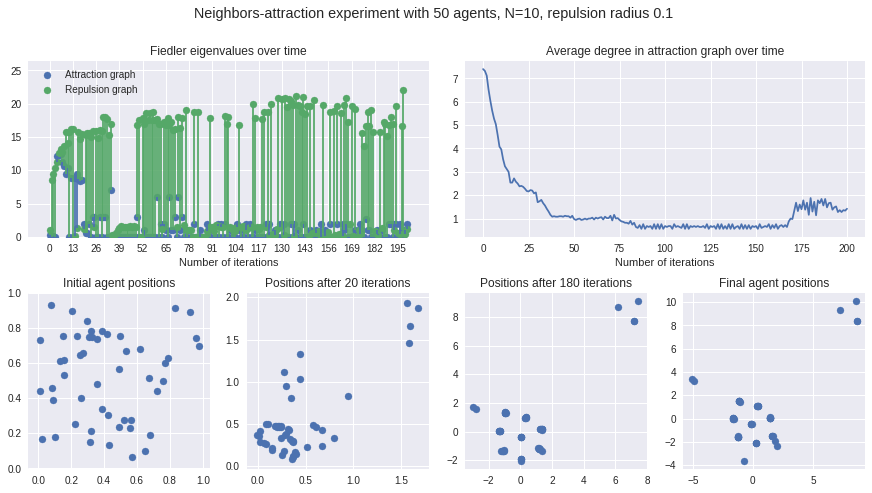

In [0]:
run_experiment(50, 'neighbors', 10, 0.1, 0.3, 0.35)  

Run neighbors-attraction experiment for 50 agents
N = 10 
Repulsion cutoff 0.4
201 iterations to convergence


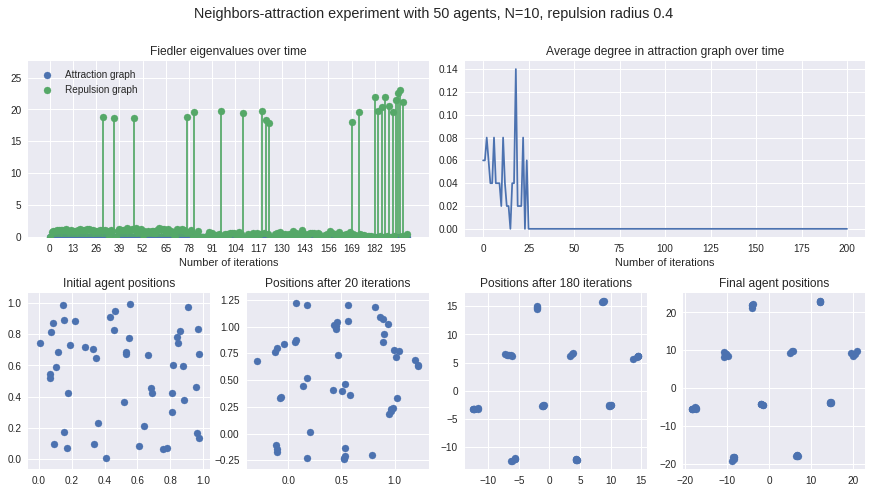

In [0]:
run_experiment(50, 'neighbors', 10, 0.4, 0.3, 0.35)  

Run neighbors-attraction experiment for 50 agents
N = 10 
Repulsion cutoff 0.4
201 iterations to convergence


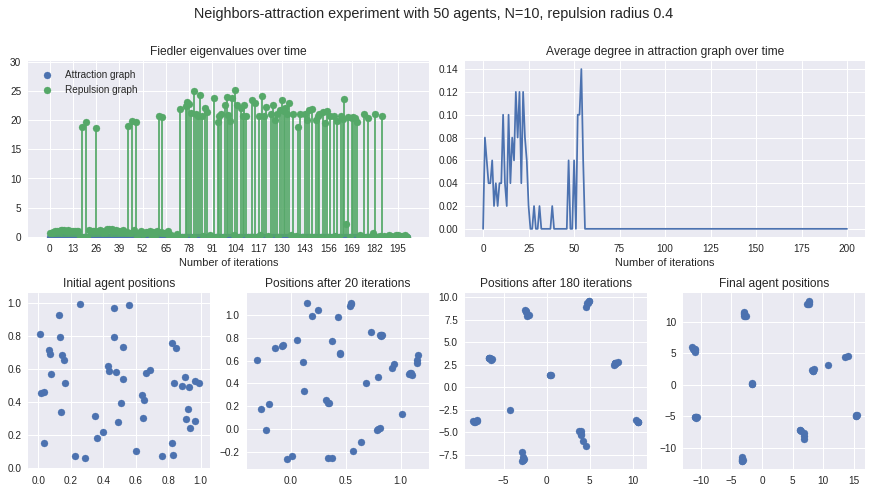

In [0]:
run_experiment(50, 'neighbors', 10, 0.4, 0.5, 0.6) 

Run neighbors-attraction experiment for 50 agents
N = 10 
Repulsion cutoff 0.1
201 iterations to convergence


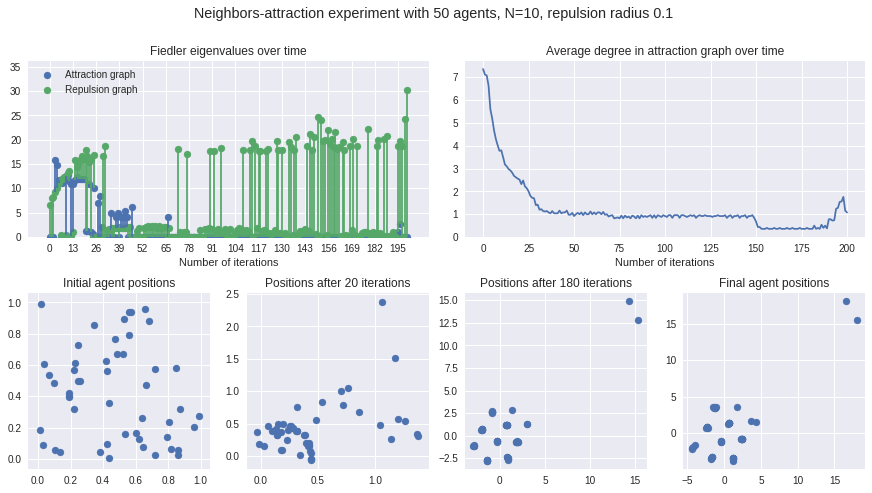

In [0]:
run_experiment(50, 'neighbors', 10, 0.1, 0.2, 0.4) 

## Small unrelated thing which is in this notebook because it was open

In [0]:
import numpy as np
r = lambda x:np.round(x,1)
pi = np.pi

def tape(hoop_diameter, tape_width, overlap, in_yards):
    
    c = np.pi*(np.pi+1)
    inches = c*hoop_diameter/(tape_width*(1.0-overlap))
    
    if in_yards:
        return inches/36.0
    else:
        return inches/12.0
    
def tape2(d, tape_width, overlap, in_yards):
    
    wp = tape_width * (1.0 - overlap)
    #print(np.sqrt(wp**2 + pi**2) - pi - 1)
    inches = pi*(d+2)/wp * np.sqrt(wp**2 + pi**2)
    
    if in_yards:
        return inches/36.0
    else:
        return inches/12.0
    

print('1.5" tape, overlap by 1/4, 1/3, 1/2, and 2/3:')
for d in range(32,41):
    print(str(d)+'":', [r(tape(d, 1.5, x, True)) for x in (1/4,1/3,1/2,2/3)],
         "\n\t", [r(tape2(d, 1.5, x, True)) for x in (1/4,1/3,1/2,2/3)], "\n")
    

print('\n3/4" tape, overlap by 0, 1/4, 1/3, 1/2:')
for d in range(32,41):
    print(str(d)+'":', [r(0.1*tape(d, 3/4, x, False)) for x in (0,1/4,1/3,1/2)],
         "\n\t",[r(0.1*tape2(d, 0.75, x, False)) for x in (0,1/4,1/3,1/2)],"\n")


1.5" tape, overlap by 1/4, 1/3, 1/2, and 2/3:
32": [10.3, 11.6, 15.4, 23.1] 
	 [8.8, 9.8, 12.8, 18.9] 

33": [10.6, 11.9, 15.9, 23.9] 
	 [9.1, 10.1, 13.2, 19.4] 

34": [10.9, 12.3, 16.4, 24.6] 
	 [9.3, 10.4, 13.5, 20.0] 

35": [11.2, 12.6, 16.9, 25.3] 
	 [9.6, 10.6, 13.9, 20.5] 

36": [11.6, 13.0, 17.3, 26.0] 
	 [9.8, 10.9, 14.3, 21.1] 

37": [11.9, 13.4, 17.8, 26.7] 
	 [10.1, 11.2, 14.7, 21.7] 

38": [12.2, 13.7, 18.3, 27.5] 
	 [10.4, 11.5, 15.0, 22.2] 

39": [12.5, 14.1, 18.8, 28.2] 
	 [10.6, 11.8, 15.4, 22.8] 

40": [12.9, 14.5, 19.3, 28.9] 
	 [10.9, 12.1, 15.8, 23.3] 


3/4" tape, overlap by 0, 1/4, 1/3, 1/2:
32": [4.6, 6.2, 6.9, 9.3] 
	 [3.8, 5.1, 5.7, 7.5] 

33": [4.8, 6.4, 7.2, 9.5] 
	 [3.9, 5.2, 5.8, 7.7] 

34": [4.9, 6.6, 7.4, 9.8] 
	 [4.1, 5.3, 6.0, 8.0] 

35": [5.1, 6.7, 7.6, 10.1] 
	 [4.2, 5.5, 6.2, 8.2] 

36": [5.2, 6.9, 7.8, 10.4] 
	 [4.3, 5.6, 6.3, 8.4] 

37": [5.3, 7.1, 8.0, 10.7] 
	 [4.4, 5.8, 6.5, 8.6] 

38": [5.5, 7.3, 8.2, 11.0] 
	 [4.5, 5.9, 6.7, 8.8] 

39": [5.6, 